# 市区町村のポリゴン作成

使用するデータ：[国土数値情報 \| 行政区域データ](https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03-v3_1.html)

上記全国版のオリジナルのファイルを用いることもできるが、以下のような問題がある。
- ファイルサイズが大きい(1GB以上)
- 一つの自治体に対して複数のフィールドを持つため、結合などの処理が面倒

上記問題を解決するため、geometryを六角形メッシュ状に簡略化し、各自治体毎に1行にまとめたGISファイルを作成した。

六角形メッシュとすることで相当程度拡大しても視認性に違和感なく、ファイルサイズを15MB程度に縮小できた。


## 行政区域データのダウンロード

全国版のデータもあるが、処理する上で読み込みに時間が掛かるため、都道府県毎にデータを取得する。

In [115]:
RAW_PATH = 'raw/kukaku'

In [116]:
import urllib.request as rq
import os

def download_data(n):
    name = f'{n:02}'
    
    url = f'https://nlftp.mlit.go.jp/ksj/gml/data/N03/N03-2022/N03-20220101_{name}_GML.zip'
    
    save_path = f'{RAW_PATH}/{name}.zip'
    
    if os.path.exists(save_path): return
    
    print(f'downloading {name}... ', end='')
    with open(save_path, "wb") as f:
        f.write(rq.urlopen(url).read())
        
    print("done!!")

In [ ]:
for i in range(1, 48):
    download_data(i)

## データ整形


In [117]:
import pandas as pd
import geopandas as gpd
import h3pandas

In [118]:
def preproc(n, resolution):
    
    df = gpd.read_file(f'{RAW_PATH}/{n:02}.zip')
    df = df[~df['N03_007'].isna()]
    
    new = []
    df["area"] = df.area
    
    for code in df["N03_007"].unique():
        new.append(
            df[df["N03_007"] == code]
            .sort_values(by="area").tail(3)
            .h3.polyfill_resample(resolution)
            .dissolve()
        )
        
    df = pd.concat(new)
    
    # 政令指定都市の場合、行政区域のデータはあるが
    # "市"としてのデータがないので作る
    new = []
    for name in df.N03_003.unique():
        if not str(name).endswith("市"): continue
        
        cdf = df[df.N03_003 == name]
        cdf.N03_004 = name
        cdf.N03_007 = f'{int(cdf.N03_007.min()) - 1:05}'
        new.append(cdf.h3.polyfill_resample(resolution).dissolve())
        
    return pd.concat([df, *new])

処理の実施。5分ほど掛かる。

ポリゴンの粒度を細かくしたい場合は`preproc`関数に渡す第2引数を`9`や`10`などにするとよい。(その分処理時間は倍増する)

In [ ]:
jp = []

for i in range(1, 48):
    jp.append(preproc(i, 8))

jpdf = (
    pd.concat(jp)
    .rename(columns={
        "N03_001": "都道府県名", 
        "N03_004": "市区町村名", 
        "N03_007": "code"})
    .set_index("code")
)

## お試し描画

首都圏を描画してみる

In [63]:
import plotly.express as px

In [182]:
def plot(gdf):
    fig = px.choropleth_mapbox(gdf,
                               geojson=gdf.geometry,
                               locations=gdf.index,
                               hover_name="市区町村名",
                               center={"lat": 35.6, "lon": 139.75},
                               mapbox_style="open-street-map",
                               zoom=7.5)
    fig.update_layout(height=600)
    fig.show(width=100)

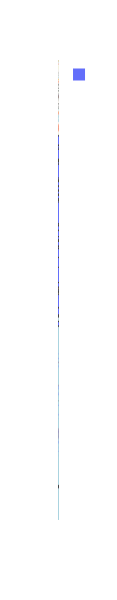

In [185]:
plot(jpdf[jpdf["都道府県名"].str.contains("埼玉県|東京都|神奈川県|千葉県")])

## ファイル出力

GISファイルとして出力する。  
ここでは`geojson`ファイルにしているが、シェープファイルにすることもできる。

### 団体コードとポリゴンのみ

In [124]:
jpdf.loc[:, ["geometry"]].to_file("sikuchoson.json", driver='GeoJSON')

### 団体コードとポリゴンと市区町村名

In [125]:
jpdf.loc[:, ["市区町村名", "geometry"]].to_file("sikuchoson_name.json", driver='GeoJSON')

### 団体コードとポリゴンと市区町村名と都道府県名

In [126]:
jpdf.loc[:, ["都道府県名", "市区町村名", "geometry"]].to_file("sikuchoson_name_pref.json", driver='GeoJSON')